In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
pip install vaderSentiment


                                              0.0/126.0 kB ? eta -:--:--
     ---------------------------------------- 126.0/126.0 kB ? eta 0:00:00


In [ ]:
import pandas as pd
import re


attendees = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\attendees.csv")
attendees['Name_lower'] = attendees['Name'].str.lower()


celeb_aliases = {name: [name] for name in attendees['Name_lower']}


celeb_aliases.update({
    'kim kardashian': ['kim kardashian', 'kim k'],
    'lil nas x': ['lil nas x', 'nas x', 'lil nas'],
    'aoc': ['aoc', 'alexandria ocasio-cortez'],
    'billie eilish': ['billie eilish', 'billie'],
    'rosé': ['rosé', 'rose', 'park chaeyoung'],
    'rihanna': ['rihanna', 'riri', 'ri ri'],
    'teyana taylor': ['teyana taylor', 'teyana']
})


df = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\processed\youtube_comments_processed.csv")
df['text'] = df['text'].astype(str)


def detect_mentions(text):
    if not isinstance(text, str):
        return []
    mentions = []
    text = text.lower()
    for canonical, aliases in celeb_aliases.items():
        for alias in aliases:
            if re.search(r'\b' + re.escape(alias) + r'\b', text):
                mentions.append(canonical)
                break  
    return mentions

df['mentioned_celebs'] = df['text'].apply(detect_mentions)
df_exploded = df.explode('mentioned_celebs').dropna(subset=['mentioned_celebs'])


mention_counts = (
    df_exploded
    .groupby(['met_gala_year', 'mentioned_celebs'])
    .size()
    .reset_index(name='mentions')
)


top_5_per_year = (
    mention_counts
    .sort_values(['met_gala_year', 'mentions'], ascending=[True, False])
    .groupby('met_gala_year')
    .head(5)
)


name_map = attendees.drop_duplicates(subset='Name_lower')[['Name_lower', 'Name']]
top_5_per_year = top_5_per_year.merge(
    name_map, left_on='mentioned_celebs', right_on='Name_lower', how='left'
)


top_5_per_year = (
    top_5_per_year
    .dropna(subset=['Name'])  #
    .rename(columns={'Name': 'Celebrity', 'met_gala_year': 'Year'})
    [['Year', 'Celebrity', 'mentions']]
    .sort_values(['Year', 'mentions'], ascending=[True, False])
)


print(top_5_per_year)


    Year      Celebrity  mentions
0   2021           Rosé       266
1   2021        Rihanna       212
2   2021          Ciara       185
4   2021           Iman       173
5   2022          Lizzo        97
6   2022           Rosé        49
7   2022  Billie Eilish        37
8   2022        Rihanna        36
9   2022      Awkwafina        23
10  2023        Rihanna       286
11  2023           Rosé       168
12  2023        Zendaya        67
13  2023          Lizzo        26
14  2023  Teyana Taylor        24
15  2024        Zendaya       409
16  2024           Rosé       118
17  2024          Lizzo        80
18  2024        Shakira        50
19  2024        Rihanna        29
20  2025        Zendaya       251
21  2025           Rosé       183
22  2025        Rihanna       173
23  2025  Teyana Taylor       171
24  2025        Shakira        62


In [ ]:
print(df['met_gala_year'].value_counts().sort_index())


2022    29145
2023     8016
2024    13295
2025    21620
Name: year, dtype: int64


    Year      Celebrity  Mentions  Avg Sentiment  \
20  2025        Zendaya       241          0.247   
21  2025           Rosé       183          0.185   
22  2025        Rihanna       173          0.139   
23  2025  Teyana Taylor       142          0.213   
24  2025        Shakira        59          0.109   

                                   Top Positive Quote  \
20  this video screams quality. your deep knowledg...   
21    jennie rose slayed it i love you girls🤩🤩😍😍😍😍🥰🥰🥰   
22  Re the corset style with the baby bump...for m...   
23  This is my first time seeing your video and I ...   
24              Shakira was one of the best fits lowk   

                                   Top Negative Quote  
20  WHAT THE HELL IS THIS?????🤷🏽‍♀️🤷🏽‍♀️🤦🏽‍♀️🤦🏽‍♀️...  
21  Shout out to rose, Lisa,  Jennie and S. Coups ...  
22  @ man shut up 😆 she’s just a average looking n...  
23  Teyana and Lewis Hamilton, Bad Bunny and Andre...  
24               Shakiras outfit was the worst for me  


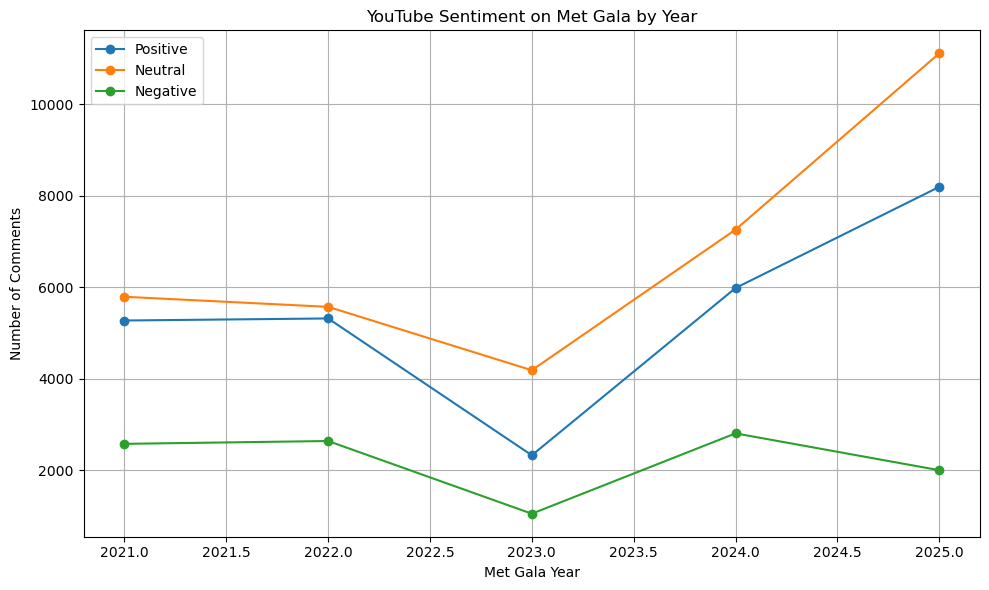

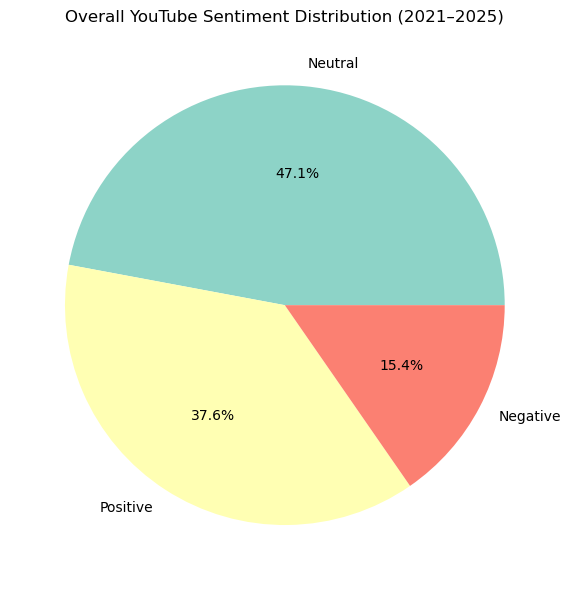

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# === Load Data ===
df_processed = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\processed\youtube_comments_processed.csv")
df_raw = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\raw\youtube_comments.csv")

df_processed = df_processed.reset_index()
df_raw = df_raw.reset_index().rename(columns={'text': 'raw_text'})
df_merged = df_processed.merge(df_raw[['index', 'raw_text']], on='index', how='left')

# === Slang Boost Dictionaries ===
modern_positive_slang = {
    'slay': 3.0, 'fire': 3.0, 'lit': 2.5, 'queen': 2.5, 'iconic': 2.7, 'goals': 2.5, 'stan': 3.0,
    'vibe': 1.5, 'periodt': 2.5, 'glowing': 2.0, 'obsessed': 2.5, "chef's kiss": 3.0,
    'serve': 2.5, 'ate': 3.0, 'baddie': 2.5, 'snatched': 2.5, 'yas': 2.5, 'slaps': 2.0,
    'bop': 2.0, 'glow up': 2.5, 'goated': 3.0, 'wig': 2.5, 'flex': 1.5, 'lowkey': 0.5,
    'highkey': 1.5, 'drop': 1.0,
}
modern_negative_slang = {
    'basic': -1.5, 'mid': -2.0, 'cringe': -2.5, 'yikes': -2.0, 'boomer': -1.5, 'karen': -2.5,
    'trash': -3.0, 'flop': -2.5, 'cancelled': -2.5, 'sus': -1.5, 'drama': -1.5, 'ghost': -2.0,
    'toxic': -3.0, 'triggered': -1.5, 'gaslighting': -3.0, 'problematic': -2.0, 'fell off': -2.0,
    'fumbled': -2.0, 'cap': -1.5, 'pressed': -1.5, 'brutal': -2.0, 'tea': -1.0, 'shade': -1.5,
    'fake': -2.0, 'dead': -0.5,
}

def adjust_score_for_slang(text, base_score):
    if not isinstance(text, str):
        text = ""
    score = base_score
    text = text.lower()
    for word, value in modern_positive_slang.items():
        if word in text:
            score += value * 0.1
    for word, value in modern_negative_slang.items():
        if word in text:
            score += value * 0.1
    return max(min(score, 1.0), -1.0)

# === Sentiment Scoring ===
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    return adjust_score_for_slang(text, score)

df_merged['compound'] = df_merged['text'].apply(analyze_sentiment)

def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df_merged['sentiment_label'] = df_merged['compound'].apply(label_sentiment)
df_merged['sentiment'] = df_merged['compound']  # shorthand

# === Updated Top 5 Celebs by Year ===
top_celebs_by_year = {
    2021: ['Rosé', 'Rihanna', 'Ciara', 'Iman', 'Zendaya'],
    2022: ['Lizzo', 'Rosé', 'Billie Eilish', 'Rihanna', 'Awkwafina'],
    2023: ['Rihanna', 'Rosé', 'Zendaya', 'Lizzo', 'Teyana Taylor'],
    2024: ['Zendaya', 'Rosé', 'Lizzo', 'Shakira', 'Rihanna'],
    2025: ['Zendaya', 'Rosé', 'Rihanna', 'Teyana Taylor', 'Shakira']
}

# === Flexible Matching with Aliases ===
celeb_aliases = {
    'rosé': ['rosé', 'rose', 'park chaeyoung'],
    'rihanna': ['rihanna', 'riri', 'ri ri'],
    'ciara': ['ciara'],
    'iman': ['iman'],
    'zendaya': ['zendaya'],
    'lizzo': ['lizzo'],
    'billie eilish': ['billie eilish', 'billie'],
    'awkwafina': ['awkwafina'],
    'shakira': ['shakira'],
    'teyana taylor': ['teyana taylor', 'teyana']
}

def detect_mentioned_celebs(text):
    if not isinstance(text, str):
        return None
    text = text.lower()
    for canonical, aliases in celeb_aliases.items():
        for alias in aliases:
            if re.search(r'\b' + re.escape(alias) + r'\b', text):
                return canonical
    return None

df_merged['mentioned_celebs'] = df_merged['text'].apply(detect_mentioned_celebs)

# === Sentiment Summary by Celebrity and Year ===
def get_sentiment_summary(df, celeb_name, year):
    filtered = df[
        (df['mentioned_celebs'] == celeb_name.lower()) &
        (df['met_gala_year'] == year)
    ]
    if filtered.empty:
        return None
    avg_score = round(filtered['sentiment'].mean(), 3)
    pos = filtered[filtered['sentiment'] > 0.7].sort_values(by='sentiment', ascending=False).head(1)
    neg = filtered[filtered['sentiment'] < -0.5].sort_values(by='sentiment').head(1)
    return {
        'Mentions': len(filtered),
        'Avg Sentiment': avg_score,
        'Top Positive Quote': pos['raw_text'].values[0] if not pos.empty else "N/A",
        'Top Negative Quote': neg['raw_text'].values[0] if not neg.empty else "N/A"
    }

summary_rows = []
for year, celeb_list in top_celebs_by_year.items():
    for celeb in celeb_list:
        result = get_sentiment_summary(df_merged, celeb, year)
        if result:
            summary_rows.append({
                'Year': year,
                'Celebrity': celeb.title(),
                'Mentions': result['Mentions'],
                'Avg Sentiment': result['Avg Sentiment'],
                'Top Positive Quote': result['Top Positive Quote'],
                'Top Negative Quote': result['Top Negative Quote']
            })

df_all_sentiment = pd.DataFrame(summary_rows)
print(df_all_sentiment[df_all_sentiment['Year'] == 2025])

# === Optional: Sentiment Trend Plot (using met_gala_year) ===
plt.figure(figsize=(10, 6))
for label in ["Positive", "Neutral", "Negative"]:
    counts = df_merged[df_merged['sentiment_label'] == label]['met_gala_year'].value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker='o', label=label)

plt.title("YouTube Sentiment on Met Gala by Year")
plt.xlabel("Met Gala Year")
plt.ylabel("Number of Comments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Optional: Overall Sentiment Pie Chart ===
sentiment_counts = df_merged['sentiment_label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=["#8dd3c7", "#ffffb3", "#fb8072"])
plt.title("Overall YouTube Sentiment Distribution (2021–2025)")
plt.tight_layout()
plt.show()


In [54]:
print(df_all_sentiment[df_all_sentiment['Year'] == 2024])

    Year Celebrity  Mentions  Avg Sentiment  \
15  2024   Zendaya       399          0.230   
16  2024      Rosé       118          0.139   
17  2024     Lizzo        72          0.008   
18  2024   Shakira        48          0.070   
19  2024   Rihanna        28          0.088   

                                   Top Positive Quote  \
15  If the celebs read the short story , “The Gard...   
16  Main issue is that you have a PHD college leve...   
17   @psycherevivedby Wow, certain dresses complem...   
18                              ❤Shakira i love Queen   
19  i’m so over the long ass skirts. it’s like the...   

                                   Top Negative Quote  
15  zendaya first look 1, hadid 2, lana 3, sevigny...  
16  If Cardi's dress was meant to be a black rose ...  
17  Lizzo even being forgotten to be put on the wo...  
18  Kim Hoedashian looked a hot mess, it looks lik...  
19  ​ @helenab9973  I think she can't really sit b...  


In [55]:
print(df_all_sentiment[df_all_sentiment['Year'] == 2023])

    Year      Celebrity  Mentions  Avg Sentiment  \
10  2023        Rihanna       278          0.084   
11  2023           Rosé       168          0.037   
12  2023        Zendaya        43         -0.023   
13  2023          Lizzo        20          0.190   
14  2023  Teyana Taylor        22          0.315   

                                   Top Positive Quote  \
10  Luc,sweetie, you are wearing my favo shirt aga...   
11  Rose did not even shine last time 😂 jennie is ...   
12                                                N/A   
13  Doja looked FAB!:cat-orange-whistling::cat-ora...   
14  Someone needs to roast your outfit. Lmao just ...   

                                   Top Negative Quote  
10  Honestly I disagree Rihanna killed it it’s NOT...  
11  Imagine Rahul Misra reimagining paris to bomba...  
12  Kardashians worst dressed where is Blake and z...  
13  Lizzo had the must disappointing  dress her he...  
14  I watched two whole videos to hear you talk ab...  


In [56]:
print(df_all_sentiment[df_all_sentiment['Year'] == 2022])

   Year      Celebrity  Mentions  Avg Sentiment  \
5  2022          Lizzo        97          0.210   
6  2022           Rosé        49         -0.138   
7  2022  Billie Eilish        36          0.321   
8  2022        Rihanna        36          0.095   
9  2022      Awkwafina        20          0.070   

                                  Top Positive Quote  \
5  Luc, you look smashing dear! First of all: Kim...   
6  Jesus is coming back. Are you ready? Have you ...   
7  oh pls- 1st of all u did not appreciate billie...   
8  Everyone for the most part looked great. Great...   
9                                                N/A   

                                  Top Negative Quote  
5   @ilovefinn1578  Totally got the idiotic theme...  
6  The gospel:  we were all born into sin, separa...  
7  Worst Kim;  why would she stuff herself into a...  
8  I love that you called out all these celebriti...  
9  Awkwafina’s gown is one of the ugliest pieces ...  


In [57]:
print(df_all_sentiment[df_all_sentiment['Year'] == 2021])

   Year Celebrity  Mentions  Avg Sentiment  \
0  2021      Rosé       266          0.089   
1  2021   Rihanna       209          0.161   
2  2021     Ciara       175          0.244   
3  2021      Iman       151          0.224   
4  2021   Zendaya        10         -0.188   

                                  Top Positive Quote  \
0  Hello Was waiting to see what is Reaction was ...   
1  Underwhelmed asF. It was evident being cute wa...   
2  ciara is also wearing russell wilson’s super b...   
3  @Reputationsbutera ♡ honestly for me it was Al...   
4                                                N/A   

                                  Top Negative Quote  
0  Sad that Luke didn't roast Rosé. Cause that ha...  
1  rihanna’s look was inspired by the “hoodie ste...  
2  please cover Quannah Chasinghorse, CL, the MAR...  
3  U have to admit that Kim k really served.. com...  
4            I miss Zendaya. She would’ve killed it🤧  
